## System steup

In [13]:
from moleculekit.molecule import Molecule
import os
import importlib
from torchmdexp.losses.rmsd import rmsd
from torchmdexp.losses.tmscore import tm_score
from torchmdexp.samplers.utils import get_native_coords, get_embeddings
from moleculekit.projections.metricrmsd import MetricRmsd
from moleculekit.projections.metrictmscore import MetricTMscore
import numpy as np
import torch

device = "cuda:0"
precision = torch.float
#8kcenters_tm_0.6_128p

In [14]:
domain = '1jfk'
ref_pdb = f'/workspace7/torchmd-AD/carles_cath/9b_good_domains/{domain}.pdb'
ref_psf = f'/workspace7/torchmd-AD/carles_cath/9b_good_topology/{domain}.psf'

ref_mol = Molecule(ref_pdb)
ref_mol.filter('name CA')
ref_mol.read(ref_psf)

mol = ref_mol

In [15]:
native_coords = get_native_coords(ref_mol, device)
native_coords = native_coords.type(precision)
coords = get_native_coords(mol, device)
coords = coords.type(precision)

print('Starting rmsd: ', rmsd(coords, native_coords))

Starting rmsd:  tensor(0.0076, device='cuda:0')


In [16]:
from torchmd.forcefields.forcefield import ForceField
from torchmd.parameters import Parameters


ff = ForceField.create(mol, '/shared/carles/repo/torchmd-exp/data/ca_priors-dihedrals_general.yaml')
parameters = Parameters(ff, mol, precision=precision, device=device)

In [17]:
from torchmd.integrator import maxwell_boltzmann
from torchmd.systems import System

system = System(mol.numAtoms, nreplicas=1, precision=precision, device=device)
system.set_positions(mol.coords)
system.set_box(mol.box)
system.set_velocities(maxwell_boltzmann(parameters.masses, T=350, replicas=1))

In [18]:
get_embeddings(mol, 'cpu', 1)

tensor([[15,  1,  6,  1, 20,  3, 19,  6, 21,  5, 14,  9,  2,  5,  2,  1, 14, 12,
          4,  6,  6, 14, 19,  1,  3, 14, 12, 19, 19, 18,  1, 21, 19,  9,  6, 10,
         20, 20, 10, 20, 21,  3, 19, 12, 21,  5,  1,  5,  2,  9,  2,  6, 21,  5,
         10,  9,  6,  3,  1, 19,  3,  4,  2, 12, 21, 10,  2, 10,  5, 20, 12,  5,
          5, 19, 21,  2, 20, 19, 14, 20,  4, 19, 20, 15,  5, 14,  5,  2,  5,  2,
         19, 20, 13, 19,  6,  6, 14, 13, 12,  3,  3, 19, 19, 11,  2, 21,  6, 19,
         14,  1,  6, 10, 14, 15, 19,  1,  5,  1,  9,  2,  5,  2,  4, 21, 13, 20,
          6,  6,  3, 20,  6,  3, 12, 20]])

In [19]:
externalmodule = importlib.import_module('torchmdnet.calculators')
nnp = '/shared/carles/repo/torchmd-exp/scripts/trainings/tests/test_cath/cath_128_levels/dih_general_tm_0.6/'
nnp += 'epoch=1233-train_loss=1.0127-val_loss=0.6081.ckpt'
embeddings = torch.tensor([15,  1,  6,  1, 20,  3, 19,  6, 21,  5, 14,  9,  2,  5,  2,  1, 14, 12,
          4,  6,  6, 14, 19,  1,  3, 14, 12, 19, 19, 18,  1, 21, 19,  9,  6, 10,
         20, 20, 10, 20, 21,  3, 19, 12, 21,  5,  1,  5,  2,  9,  2,  6, 21,  5,
         10,  9,  6,  3,  1, 19,  3,  4,  2, 12, 21, 10,  2, 10,  5, 20, 12,  5,
          5, 19, 21,  2, 20, 19, 14, 20,  4, 19, 20, 15,  5, 14,  5,  2,  5,  2,
         19, 20, 13, 19,  6,  6, 14, 13, 12,  3,  3, 19, 19, 11,  2, 21,  6, 19,
         14,  1,  6, 10, 14, 15, 19,  1,  5,  1,  9,  2,  5,  2,  4, 21, 13, 20,
          6,  6,  3, 20,  6,  3, 12, 20]).repeat(1, 1)
external = externalmodule.External(nnp, embeddings, device)

In [20]:
from torchmd.forces import Forces
external=None
forces = Forces(parameters,terms=['bonds', 'repulsioncg', 'dihedrals'], cutoff=9, rfa=False, switch_dist=None, 
                external=external, exclusions = ('bonds')
               )
# Evaluate current energy and forces. Forces are modified in-place
Epot = forces.compute(system.pos, system.box, system.forces, returnDetails=False)
print(Epot)

[219.66205024719238]


## Dynamics

In [21]:
from torchmd.integrator import Integrator
from torchmd.wrapper import Wrapper

langevin_temperature = 550  # K
langevin_gamma = 1
timestep = 5  # fs

integrator = Integrator(system, forces, timestep, device, gamma=langevin_gamma, T=langevin_temperature)
wrapper = Wrapper(mol.numAtoms, mol.bonds if len(mol.bonds) else None, device)

 27%|██████████▌                            | 1354/5000 [14:58<40:18,  1.51it/s]


KeyboardInterrupt: 

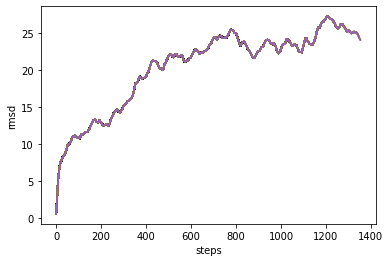

In [22]:
from tqdm import tqdm 
import numpy as np
%matplotlib inline
import time
import pylab as pl
from IPython import display

FS2NS = 1E-6 # Femtosecond to nanosecond conversion

steps = 100000
output_period = 20
save_period = 20
traj = []

trajectoryout = "mytrajectory.npy"

iterator = tqdm(range(1, int(steps / output_period) + 1))
Epot = forces.compute(system.pos, system.box, system.forces)
rmsds = []
Ep = []
tm_scores = []
for i in iterator:
    Ekin, Epot, T = integrator.step(niter=output_period)
    wrapper.wrap(system.pos, system.box)
    currpos = system.pos.detach().cpu().numpy().copy()
    traj.append(currpos)

    rmsds.append(rmsd(system.pos, native_coords).item())
    Ep.append(Epot)
    
    if rmsds[-1] > 40:
        break
    pl.plot(rmsds)
    pl.xlabel('steps')
    pl.ylabel('rmsd')
    
    display.clear_output(wait=True)
    display.display(pl.gcf())

In [23]:
import copy
tmp_mol = copy.deepcopy(mol)
mol_xtc = Molecule(ref_psf)
rmsd_proj = MetricRmsd(ref_mol, 'name CA', centerstr='name CA', pbc=False)
rmsd_range = [0,2]
for conf in traj:
    tmp_mol.coords = np.moveaxis(conf, 0, -1)
    tmp_mol.align('name CA', refmol=ref_mol)
    rmsd_value = rmsd_proj.project(tmp_mol)
    
    if rmsd_range[0] <= rmsd_value.item() <= rmsd_range[1]:
        print(rmsd_value)
        mol_xtc.appendFrames(tmp_mol)
        rmsd_range = [ x + 3.5 for x in rmsd_range]
    

0.61319286
3.5123987
7.1169643
10.5395155
14.049708
17.543365
21.040133
24.531906


In [24]:
mol_xtc.box = np.zeros(shape=(3,mol_xtc.numFrames), dtype=np.float32)
mol_xtc.write(f'/workspace7/torchmd-AD/carles_cath/9b_good_xtc/{domain}_kcenters_8clusters.xtc')